# Classify images according to isCancerous
In this notebook the goal is to classify the images according to their isCancerous state (0 or 1)

# Setup
1. Import libraries
2. Setting up data sets
3. Initialize learning curve function

We will also concatenate data_labels_mainData.csv and data_labels_extraData.csv together for this model as both contains data for the column isCancerous.

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'2.3.0'

In [25]:
from sklearn.model_selection import train_test_split


data1 = pd.read_csv('./data_labels_mainData.csv')
data2 = pd.read_csv('./data_labels_extraData.csv')

data1.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [26]:
data2.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [27]:
data1_edited = data1.drop(columns=['cellTypeName', 'cellType'])

In [28]:
concatenated_dataframe = pd.concat([data1_edited, data2])

In [29]:
print(data1.shape)
print(data2.shape)
print(concatenated_dataframe.shape)

(9896, 6)
(10384, 4)
(20280, 4)


In [30]:
data = concatenated_dataframe
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


# EDA

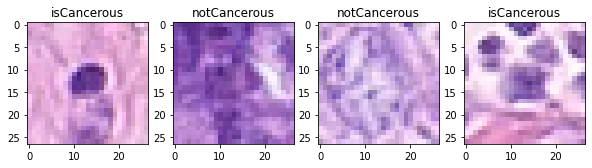

In [31]:
from PIL import Image

label_names = {'isCancerous' : 0, 'notCancerous' : 1}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['isCancerous']
target_list = list(target)

fig = plt.figure(figsize=[10,10])

for i in np.arange(4):
    plt.subplot(1, 4, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

In [32]:
# check image size

img = Image.open(img_list[100])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH:{} W:{} C:{}'.format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size 
H:27 W:27 C:3


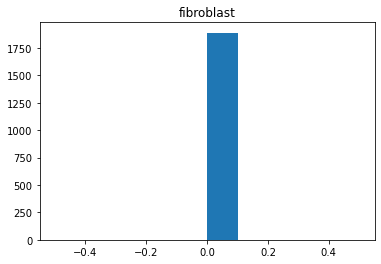

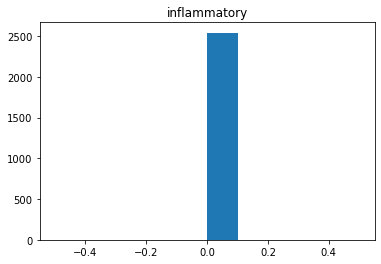

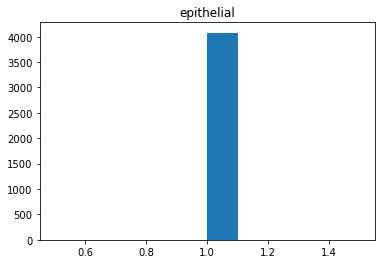

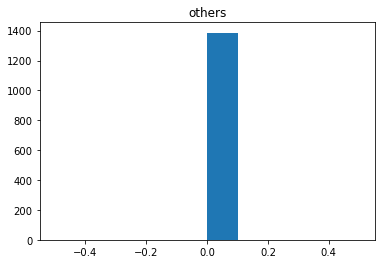

In [33]:
fibroblast = data1[data1['cellType']==0]
inflammatory = data1[data1['cellType']==1]
epithelial = data1[data1['cellType']==2]
others = data1[data1['cellType']==3]


plt.hist(fibroblast['isCancerous'])
plt.title('fibroblast')
plt.show()

plt.hist(inflammatory['isCancerous'])
plt.title('inflammatory')
plt.show()

plt.hist(epithelial['isCancerous'])
plt.title('epithelial')
plt.show()

plt.hist(others['isCancerous'])
plt.title('others')
plt.show()

Observation: An interesting revalation occur, apparently cell type fibroblast, inflammatory and other does not have isCancerous lable while cell type epithelial does not have notCancerous label. 

From the observation above, it would not be smart to have 4 models handling each type of cell. Sorry if this contracdict with what I said above but I tried to avoid a "Zero Frequency Probem"

## Further setups

In [35]:
# learning curve function
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()
    
# cellType needs to be string
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [37]:
# initializing data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


# 1) NN model as Base model
We will use a simple NN model using Keras Sequential for our base model

In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

model_cancer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model_cancer.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history = model_cancer.fit(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Parameters Tuning for base model
### Regularization
Tuning the lambda value for l2 regulurization

In [ ]:
reg_lambda = 0.02

model_cancer_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_cancer_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_reg = model_cancer_reg.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

plot_learning_curve(history_cancer_reg.history['loss'], history_cancer_reg.history['val_loss'], 
                    history_cancer_reg.history['categorical_accuracy'], history_cancer_reg.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Drop out
Next we try to add a dropout layer to regularize the model

In [ ]:
model_cancer_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model_cancer_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_drop = model_cancer_drop.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

plot_learning_curve(history_cancer_drop.history['loss'], history_cancer_drop.history['val_loss'], 
                    history_cancer_drop.history['categorical_accuracy'], history_cancer_drop.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Cross validation to train the model

In [38]:
from sklearn.model_selection import KFold, StratifiedKFold

Y = train_data[['isCancerous']]
kf = KFold(n_splits = 10)
Y

,isCancerous
233,0
7782,1
2371,1
5032,0
9768,0
...,...
8528,0
1897,1
3995,1
6833,0


In [ ]:
idg = ImageDataGenerator(rescale=1./255, data_format='channels_last')

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/cancer_CV/'
fold_var = 1
reg_lambda = 0.02

for train_index, val_index in kf.split(Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
    
    train_datagen = idg.flow_from_dataframe(dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
    valid_datagen  = idg.flow_from_dataframe(dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
       


    # CREATE NEW MODEL
    model_cancer_CV = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
    # COMPILE NEW MODEL
    model_cancer_CV.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history_CV = model_cancer_CV.fit(train_datagen,
                epochs=200,
                callbacks=callbacks_list,
                validation_data= valid_datagen,
                verbose=1)
    #PLOT HISTORY
    #       :
    #       :

    # LOAD BEST MODEL to evaluate the performance of the model
   
    model_cancer_CV.load_weights("/cancer_CV/model_"+str(fold_var)+".h5")

    results = model_cancer_CV.evaluate(valid_datagen)
    results = dict(zip(model_cancer_CV.metrics_names,results))

    VALIDATION_ACCURACY.append(results['categorical_accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1



In [ ]:
VALIDATION_ACCURACY.sort()
print("Largest element is:", VALIDATION_ACCURACY[-1])

In [ ]:
plot_learning_curve(history_CV.history['loss'], history_CV.history['val_loss'], 
                    history_CV.history['categorical_accuracy'], history_CV.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Save model

In [ ]:
# Original model without tuning
model_cancer.save("cancer_base_model")

# Model with regularization
model_cancer_reg.save("cancer_reg_base_model")

# Model with dropout
model_cancer_drop.save("cancer_dropout_base_model")
model_cancer_CV.save("cancer_CV_model")

## Testing the final model
The model tuning by dropout seems to have the best performance.

In [ ]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model_cancer.evaluate(test_generator)

In [ ]:
model_cancer_reg.evaluate(test_generator)

In [ ]:
model_cancer_drop.evaluate(test_generator)

In [ ]:
model_cancer_CV.evaluate(test_generator)

# 2) CNN model (using leNet)
Next we will experiment using CNN models, in this section we will attempt to create a CNN model using leNet

In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 2

model_cancer_leNet1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cancer_leNet1.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_cancer_leNet1 = model_cancer_leNet1.fit(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=100, verbose=0)

plot_learning_curve(history_cancer_leNet1.history['loss'], history_cancer_leNet1.history['val_loss'], 
                    history_cancer_leNet1.history['categorical_accuracy'], history_cancer_leNet1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Observation:

### Data augmentation

In [39]:
train_datagen_data_aug = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)
batch_size = 32
train_generator_data_aug = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.


In [ ]:
model_cancer_leNet2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_cancer_leNet2.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_cancer_leNet2 = model_cancer_leNet2.fit_generator(train_generator_data_aug, 
                                    validation_data = validation_generator, 
                                    epochs=150, verbose=0)

plot_learning_curve(history_cancer_leNet2.history['loss'], history_cancer_leNet2.history['val_loss'], 
                    history_cancer_leNet2.history['categorical_accuracy'], history_cancer_leNet2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Cross validation

In [ ]:
Y = train_data[['isCancerous']]
kf = KFold(n_splits = 5)
Y

In [ ]:
# idg_leNet = ImageDataGenerator(rescale=1./255, data_format='channels_last',
#                                   rotation_range=15, width_shift_range=0.2,
#                                   height_shift_range=0.2)


In [ ]:
# VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/leNet_cancer_CV/'
fold_var = 1
reg_lambda = 0.001

for train_index, val_index in kf.split(Y):
    
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
    
#     train_datagen = idg_leNet.flow_from_dataframe(dataframe=train_data,
#         directory='./patch_images/',
#         x_col="ImageName",
#         y_col="isCancerous",
#         target_size=(27, 27),
#         batch_size=batch_size,
#         class_mode='categorical')
#     valid_datagen  = idg_leNet.flow_from_dataframe(dataframe=val_data,
#         directory='./patch_images/',
#         x_col="ImageName",
#         y_col="isCancerous",
#         target_size=(27, 27),
#         batch_size=batch_size,
#         class_mode='categorical')
       


    # CREATE NEW MODEL
    model_cancer_leNet_aug_CV = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
    # COMPILE NEW MODEL
    model_cancer_leNet_CV.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])


    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history_leNet_CV = model_cancer_leNet_CV.fit(train_generator_data_aug,
                epochs=10,
                callbacks=callbacks_list,
                validation_data= validation_generator,
                verbose=1)
    #PLOT HISTORY
    #       :
    #       :

    # LOAD BEST MODEL to evaluate the performance of the model

    model_cancer_leNet_CV.load_weights("/leNet_cancer_CV/model_"+str(fold_var)+".h5")
    
    results = model_cancer_leNet_CV.evaluate(valid_datagen)
    results = dict(zip(model_cancer_leNet_CV.metrics_names,results))

    VALIDATION_ACCURACY.append(results['categorical_accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1
    print(fold_var)
    
# plot the learning curve
plot_learning_curve(history_leNet_CV.history['loss'], history_leNet_CV.history['val_loss'], 
                    history_leNet_CV.history['categorical_accuracy'], history_leNet_CV.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Observation:

## Testing the final model

In [ ]:
model_cancer_leNet1.evaluate(test_generator)

In [ ]:
model_cancer_leNet2.evaluate(test_generator)

In [ ]:
model_cancer_leNet_CV.evaluate(test_generator)

# 3) CNN model (using VGG)
Next we will experiment using CNN VGG models.

In [ ]:
OUTPUT_CLASSES = 2
model_cancer_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_cancer_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_VGG_1 = model_cancer_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

plot_learning_curve(history_cancer_VGG_1.history['loss'], history_cancer_VGG_1.history['val_loss'], 
                    history_cancer_VGG_1.history['categorical_accuracy'], history_cancer_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Observation:

### Regularization with data augmentation

In [ ]:
train_datagen_data_aug_VGG = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)

batch_size = 32

train_generator_data_aug_VGG = train_datagen_data_aug_VGG.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
OUTPUT_CLASSES = 2
model_cancer_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_cancer_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_VGG_2 = model_cancer_VGG_2.fit(train_generator_data_aug_VGG, validation_data = validation_generator, epochs=150, verbose=0)

plot_learning_curve(history_cancer_VGG_2.history['loss'], history_cancer_VGG_2.history['val_loss'], 
                    history_cancer_VGG_2.history['categorical_accuracy'], history_cancer_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Adding regularization and dropout

In [ ]:
reg_lambda = 0.001
OUTPUT_CLASSES = 2
model_cancer_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_cancer_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_VGG_3 = model_cancer_VGG_3.fit(train_generator, validation_data = validation_generator, epochs=150, verbose=0)

plot_learning_curve(history_cancer_VGG_3.history['loss'], history_cancer_VGG_3.history['val_loss'], 
                    history_cancer_VGG_3.history['categorical_accuracy'], history_cancer_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Observation:

## Testing the final model

In [ ]:
history_cancer_VGG_1.evaluate(test_generator)

In [ ]:
history_cancer_VGG_2.evaluate(test_generator)

In [ ]:
history_cancer_VGG_3.evaluate(test_generator)